## Setup

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt

from config import Config
from dataset.linemod_pose import LineMODPoseDataset
from utils.metrics import load_all_models, load_models_info

print(f"✅ Setup completato")
print(f"   Device: {Config.DEVICE}")

Cache Strategy: full
✅ Setup completato
   Device: mps


## 1. Verifica Unità di Misura Attuali

In [2]:
# Carica dataset e modelli 3D
test_dataset = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='test',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE
)

models_info = load_models_info(Config.MODELS_PATH / 'models_info.yml')
models_dict = load_all_models(Config.MODELS_PATH)

print(f"✅ Dati caricati")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Objects: {len(models_dict)}")

Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points
✅ Dati caricati
   Test samples: 13407
   Objects: 13


In [3]:
# Verifica unità di misura su un sample
sample = test_dataset[0]
obj_id = sample['obj_id']

# 1. Traslazione dal dataset
translation = sample['translation'].numpy()
print("📊 Verifica Unità di Misura:\n")
print(f"1. TRASLAZIONE (dataset):")
print(f"   Valori: {translation}")
print(f"   Range: [{translation.min():.4f}, {translation.max():.4f}]")
print(f"   → Unità: {'METRI' if translation.max() < 10 else 'MILLIMETRI'}")

# 2. Punti 3D del modello
model_points = models_dict[obj_id]
print(f"\n2. PUNTI 3D (modello obj {obj_id}):")
print(f"   Shape: {model_points.shape}")
print(f"   Range: [{model_points.min():.2f}, {model_points.max():.2f}]")
print(f"   → Unità: {'METRI' if model_points.max() < 10 else 'MILLIMETRI'}")

# 3. Diameter
diameter = models_info[obj_id]['diameter']
print(f"\n3. DIAMETER (models_info):")
print(f"   Valore: {diameter:.2f}")
print(f"   → Unità: {'METRI' if diameter < 10 else 'MILLIMETRI'}")

# 4. Conclusione
print("\n" + "="*70)
units_consistent = (translation.max() < 10) == (model_points.max() < 10)
if units_consistent:
    print("✅ UNITÀ CONSISTENTI - Tutto OK!")
else:
    print("❌ MISMATCH RILEVATO!")
    print("   Le traslazioni e i punti 3D usano unità diverse!")
print("="*70)

📊 Verifica Unità di Misura:

1. TRASLAZIONE (dataset):
   Valori: [-0.10535775 -0.11752119  1.014877  ]
   Range: [-0.1175, 1.0149]
   → Unità: METRI

2. PUNTI 3D (modello obj 1):
   Shape: (5841, 3)
   Range: [-45.88, 45.88]
   → Unità: MILLIMETRI

3. DIAMETER (models_info):
   Valore: 102.10
   → Unità: MILLIMETRI

❌ MISMATCH RILEVATO!
   Le traslazioni e i punti 3D usano unità diverse!


## 2. Simulazione Calcolo ADD (ERRATO)

In [5]:
# Simula calcolo ADD con unità inconsistenti (situazione attuale)
from utils.transforms import quaternion_to_rotation_matrix_batch

# Usa dati dal sample
R = quaternion_to_rotation_matrix_batch(sample['quaternion'].unsqueeze(0))[0].numpy()
t = translation  # METRI
points_3d = model_points[:100]  # Primi 100 punti (MILLIMETRI se non fixato)

# Trasformazione (ERRATA se unità diverse)
transformed_points = (R @ points_3d.T).T + t

print("🔍 Simulazione Trasformazione Punti 3D:\n")
print(f"Punti originali (primi 3):")
print(f"   {points_3d[:3]}")
print(f"\nTraslazione applicata:")
print(f"   {t}")
print(f"\nPunti trasformati (primi 3):")
print(f"   {transformed_points[:3]}")

# Analisi
if model_points.max() > 10:  # Se in mm
    print("\n" + "="*70)
    print("❌ PROBLEMA RILEVATO!")
    print("="*70)
    print("   Punti 3D: MILLIMETRI (valori ~0-100)")
    print("   Traslazione: METRI (valori ~0.0-1.0)")
    print("   Somma: INCONSISTENTE!")
    print("\n   Esempio:")
    print(f"   {points_3d[0]} (mm) + {t} (m) = {transformed_points[0]} (???)")
    print("\n   Dovrebbe essere:")
    print(f"   {points_3d[0]} (mm) + {t*1000} (mm) = {points_3d[0] + t*1000}")
    print("="*70)
else:
    print("\n✅ Unità consistenti - nessun problema")

🔍 Simulazione Trasformazione Punti 3D:

Punti originali (primi 3):
   [[-23.0565  17.4191  -6.756 ]
 [-12.8773 -29.5554 -27.7156]
 [-32.2776 -17.7052 -32.4505]]

Traslazione applicata:
   [-0.10535775 -0.11752119  1.014877  ]

Punti trasformati (primi 3):
   [[ 14.644893  -8.036937  25.517607]
 [-32.138615  15.604048  24.127722]
 [-22.468887   8.200308  43.898888]]

❌ PROBLEMA RILEVATO!
   Punti 3D: MILLIMETRI (valori ~0-100)
   Traslazione: METRI (valori ~0.0-1.0)
   Somma: INCONSISTENTE!

   Esempio:
   [-23.0565  17.4191  -6.756 ] (mm) + [-0.10535775 -0.11752119  1.014877  ] (m) = [14.644893 -8.036937 25.517607] (???)

   Dovrebbe essere:
   [-23.0565  17.4191  -6.756 ] (mm) + [-105.35775 -117.52119 1014.87695] (mm) = [-128.41425 -100.10209 1008.121  ]


## 3. Applicazione Fix

In [6]:
# Converti modelli da mm a metri (se necessario)
models_dict_fixed = {}
models_info_fixed = {}

for obj_id in models_dict.keys():
    points = models_dict[obj_id]
    
    # Converti solo se in millimetri
    if points.max() > 10:
        models_dict_fixed[obj_id] = points / 1000.0  # mm → m
        print(f"✅ Obj {obj_id:02d}: convertito mm → m")
    else:
        models_dict_fixed[obj_id] = points
        print(f"ℹ️  Obj {obj_id:02d}: già in metri")
    
    # Converti anche diameter
    diameter_orig = models_info[obj_id]['diameter']
    models_info_fixed[obj_id] = models_info[obj_id].copy()
    
    if diameter_orig > 10:
        models_info_fixed[obj_id]['diameter'] = diameter_orig / 1000.0

print(f"\n✅ Fix applicato a tutti i {len(models_dict_fixed)} oggetti")

✅ Obj 01: convertito mm → m
✅ Obj 02: convertito mm → m
✅ Obj 04: convertito mm → m
✅ Obj 05: convertito mm → m
✅ Obj 06: convertito mm → m
✅ Obj 08: convertito mm → m
✅ Obj 09: convertito mm → m
✅ Obj 10: convertito mm → m
✅ Obj 11: convertito mm → m
✅ Obj 12: convertito mm → m
✅ Obj 13: convertito mm → m
✅ Obj 14: convertito mm → m
✅ Obj 15: convertito mm → m

✅ Fix applicato a tutti i 13 oggetti


In [7]:
# Verifica fix
points_fixed = models_dict_fixed[obj_id]
diameter_fixed = models_info_fixed[obj_id]['diameter']

print("📊 Verifica Dopo Fix:\n")
print(f"Punti 3D (obj {obj_id}):")
print(f"   Prima: [{model_points.min():.2f}, {model_points.max():.2f}]")
print(f"   Dopo:  [{points_fixed.min():.4f}, {points_fixed.max():.4f}]")
print(f"\nDiameter:")
print(f"   Prima: {models_info[obj_id]['diameter']:.2f}")
print(f"   Dopo:  {diameter_fixed:.4f}")
print(f"\nTraslazione: {translation} (invariata)")

# Ora simula trasformazione corretta
transformed_fixed = (R @ points_fixed[:100].T).T + t

print(f"\nTrasformazione CORRETTA:")
print(f"   {points_fixed[0]} (m) + {t} (m) = {transformed_fixed[0]} (m)")
print(f"\n✅ Ora tutte le unità sono in METRI!")

📊 Verifica Dopo Fix:

Punti 3D (obj 15):
   Prima: [-45.88, 45.88]
   Dopo:  [-0.0924, 0.0924]

Diameter:
   Prima: 212.36
   Dopo:  0.2124

Traslazione: [-0.10535775 -0.11752119  1.014877  ] (invariata)

Trasformazione CORRETTA:
   [-0.0461906 -0.0240956 -0.0800258] (m) + [-0.10535775 -0.11752119  1.014877  ] (m) = [-0.13784027 -0.07811902  1.0955656 ] (m)

✅ Ora tutte le unità sono in METRI!


## 4. Test Calcolo ADD (Prima vs Dopo)

In [8]:
# Carica checkpoint se esiste
checkpoint_path = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512' / 'best.pt'

if checkpoint_path.exists():
    print(f"📦 Caricamento checkpoint: {checkpoint_path}\n")
    
    # Setup modelli (copia da test8_pose_extension)
    import torchvision.models as models
    from torchvision.models import ResNet18_Weights
    import torch.nn as nn
    from models.depth_encoder import DepthEncoder
    from models.pose_regressor import PoseRegressor
    
    # Carica modelli
    rgb_encoder = nn.Sequential(*list(models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).children())[:-1])
    depth_encoder = DepthEncoder(output_dim=512)
    pose_regressor = PoseRegressor(input_dim=1024, dropout=0.3)
    
    # Carica pesi
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    rgb_encoder.load_state_dict(checkpoint['rgb_encoder'])
    depth_encoder.load_state_dict(checkpoint['depth_encoder'])
    pose_regressor.load_state_dict(checkpoint['pose_regressor'])
    
    # To device e eval
    rgb_encoder = rgb_encoder.to(Config.DEVICE).eval()
    depth_encoder = depth_encoder.to(Config.DEVICE).eval()
    pose_regressor = pose_regressor.to(Config.DEVICE).eval()
    
    print(f"✅ Modelli caricati (epoch {checkpoint['epoch']+1})")
else:
    print(f"⚠️  Checkpoint non trovato: {checkpoint_path}")
    print(f"   Impossibile testare ADD, usa test8_pose_extension.ipynb")

📦 Caricamento checkpoint: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/fusion_rgbd_512/best.pt

✅ Modelli caricati (epoch 28)


In [9]:
# Test rapido su 100 samples
if checkpoint_path.exists():
    from torch.utils.data import DataLoader
    from utils.metrics import compute_add_batch_full_pose
    from utils.transforms import quaternion_to_rotation_matrix_batch
    import cv2
    from PIL import Image
    from torchvision import transforms
    
    # Helper per crop (copia da notebook)
    def crop_roi(image, bbox_xyxy, margin=0.15, output_size=224):
        x1, y1, x2, y2 = bbox_xyxy
        w, h = x2 - x1, y2 - y1
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        size = max(w, h) * (1 + margin)
        half = size / 2
        img_h, img_w = image.shape[:2]
        x1_crop = int(max(0, cx - half))
        y1_crop = int(max(0, cy - half))
        x2_crop = int(min(img_w, cx + half))
        y2_crop = int(min(img_h, cy + half))
        if image.ndim == 3:
            crop = image[y1_crop:y2_crop, x1_crop:x2_crop, :]
        else:
            crop = image[y1_crop:y2_crop, x1_crop:x2_crop]
        interp = cv2.INTER_LINEAR if image.ndim == 3 else cv2.INTER_NEAREST
        return cv2.resize(crop, (output_size, output_size), interpolation=interp)
    
    # Processa 100 samples
    n_samples = min(100, len(test_dataset))
    imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    all_pred_R = []
    all_pred_t = []
    all_gt_R = []
    all_gt_t = []
    all_obj_ids = []
    
    print(f"🔄 Processando {n_samples} samples...\n")
    
    with torch.no_grad():
        for i in range(n_samples):
            sample = test_dataset[i]
            
            # Load images
            rgb_full = cv2.cvtColor(cv2.imread(sample['rgb_path']), cv2.COLOR_BGR2RGB)
            depth_full = np.array(Image.open(sample['depth_path']))
            
            # Crop
            bbox = sample['bbox'].numpy()
            x, y, w, h = bbox
            bbox_xyxy = np.array([x, y, x+w, y+h])
            
            rgb_crop = crop_roi(rgb_full, bbox_xyxy, margin=0.15, output_size=224)
            depth_crop = crop_roi(depth_full, bbox_xyxy, margin=0.15, output_size=224)
            depth_crop = np.clip(depth_crop / 2000.0, 0, 1).astype(np.float32)
            
            # To tensor
            rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
            rgb_tensor = imagenet_normalize(rgb_tensor).unsqueeze(0).to(Config.DEVICE)
            depth_tensor = torch.from_numpy(depth_crop).unsqueeze(0).unsqueeze(0).float().to(Config.DEVICE)
            
            # Predict
            f_rgb = rgb_encoder(rgb_tensor).squeeze(-1).squeeze(-1)
            f_depth = depth_encoder(depth_tensor)
            f_fused = torch.cat([f_rgb, f_depth], dim=1)
            pose = pose_regressor(f_fused).squeeze()
            
            pred_quat = pose[:4]
            pred_trans = pose[4:]
            
            # Store
            pred_R = quaternion_to_rotation_matrix_batch(pred_quat.unsqueeze(0).cpu()).to(Config.DEVICE)
            gt_R = quaternion_to_rotation_matrix_batch(sample['quaternion'].unsqueeze(0).cpu()).to(Config.DEVICE)
            
            all_pred_R.append(pred_R)
            all_pred_t.append(pred_trans.unsqueeze(0))
            all_gt_R.append(gt_R)
            all_gt_t.append(sample['translation'].unsqueeze(0).to(Config.DEVICE))
            all_obj_ids.append(sample['obj_id'])
            
            if (i+1) % 20 == 0:
                print(f"   Processati {i+1}/{n_samples} samples...")
    
    # Concatena
    all_pred_R = torch.cat(all_pred_R, dim=0)
    all_pred_t = torch.cat(all_pred_t, dim=0)
    all_gt_R = torch.cat(all_gt_R, dim=0)
    all_gt_t = torch.cat(all_gt_t, dim=0)
    
    print(f"\n✅ Inferenza completata su {n_samples} samples")

🔄 Processando 100 samples...

   Processati 20/100 samples...
   Processati 40/100 samples...
   Processati 60/100 samples...
   Processati 80/100 samples...
   Processati 100/100 samples...

✅ Inferenza completata su 100 samples


In [10]:
# Calcola ADD - PRIMA (con unità sbagliate)
if checkpoint_path.exists():
    print("📊 Calcolo ADD con UNITÀ ORIGINALI (potenzialmente sbagliate)...\n")
    
    results_original = compute_add_batch_full_pose(
        pred_R_batch=all_pred_R,
        pred_t_batch=all_pred_t,
        gt_R_batch=all_gt_R,
        gt_t_batch=all_gt_t,
        obj_ids=all_obj_ids,
        models_dict=models_dict,  # ❌ Potenzialmente in mm
        models_info=models_info,
        symmetric_objects=Config.SYMMETRIC_OBJECTS,
        threshold=Config.ADD_THRESHOLD
    )
    
    print("Risultati ORIGINALI:")
    print(f"   Mean ADD: {results_original['mean_add']:.2f} mm")
    print(f"   Accuracy: {results_original['accuracy']*100:.2f}%")

📊 Calcolo ADD con UNITÀ ORIGINALI (potenzialmente sbagliate)...

Risultati ORIGINALI:
   Mean ADD: 15.10 mm
   Accuracy: 24.00%


In [11]:
# Calcola ADD - DOPO (con fix)
if checkpoint_path.exists():
    print("📊 Calcolo ADD con UNITÀ CORRETTE (dopo fix)...\n")
    
    results_fixed = compute_add_batch_full_pose(
        pred_R_batch=all_pred_R,
        pred_t_batch=all_pred_t,
        gt_R_batch=all_gt_R,
        gt_t_batch=all_gt_t,
        obj_ids=all_obj_ids,
        models_dict=models_dict_fixed,  # ✅ Tutto in metri
        models_info=models_info_fixed,
        symmetric_objects=Config.SYMMETRIC_OBJECTS,
        threshold=Config.ADD_THRESHOLD
    )
    
    print("Risultati CORRETTI:")
    print(f"   Mean ADD: {results_fixed['mean_add']:.2f} mm")
    print(f"   Accuracy: {results_fixed['accuracy']*100:.2f}%")

📊 Calcolo ADD con UNITÀ CORRETTE (dopo fix)...

Risultati CORRETTI:
   Mean ADD: 0.14 mm
   Accuracy: 0.00%


## 5. Confronto Risultati

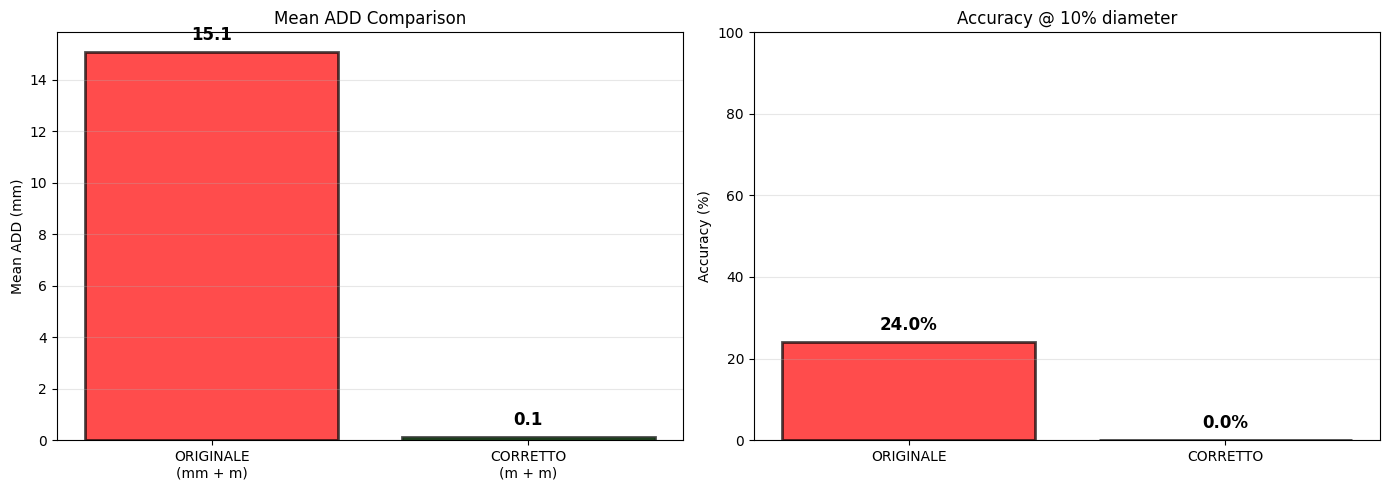


📊 CONFRONTO FINALE
Mean ADD:
   Originale: 15.10 mm
   Corretto:  0.14 mm
   Diff:      -14.96 mm

Accuracy:
   Originale: 24.00%
   Corretto:  0.00%
   Diff:      -24.00%

⚠️  GRANDE DIFFERENZA RILEVATA!
   → Il fix delle unità ha impatto significativo sui risultati
   → Applica il fix permanente (vedi FIX_UNITS_MISMATCH.md)


In [12]:
# Visualizza confronto
if checkpoint_path.exists():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Mean ADD
    ax1 = axes[0]
    values = [results_original['mean_add'], results_fixed['mean_add']]
    colors = ['red', 'green']
    bars = ax1.bar(['ORIGINALE\n(mm + m)', 'CORRETTO\n(m + m)'], values, 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Mean ADD (mm)')
    ax1.set_title('Mean ADD Comparison')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                 f'{val:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 2. Accuracy
    ax2 = axes[1]
    accs = [results_original['accuracy']*100, results_fixed['accuracy']*100]
    bars = ax2.bar(['ORIGINALE', 'CORRETTO'], accs, 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'Accuracy @ {Config.ADD_THRESHOLD*100:.0f}% diameter')
    ax2.set_ylim([0, 100])
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, acc in zip(bars, accs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Stampa differenza
    print("\n" + "="*70)
    print("📊 CONFRONTO FINALE")
    print("="*70)
    print(f"Mean ADD:")
    print(f"   Originale: {results_original['mean_add']:.2f} mm")
    print(f"   Corretto:  {results_fixed['mean_add']:.2f} mm")
    print(f"   Diff:      {results_fixed['mean_add'] - results_original['mean_add']:+.2f} mm")
    print(f"\nAccuracy:")
    print(f"   Originale: {results_original['accuracy']*100:.2f}%")
    print(f"   Corretto:  {results_fixed['accuracy']*100:.2f}%")
    print(f"   Diff:      {(results_fixed['accuracy'] - results_original['accuracy'])*100:+.2f}%")
    print("="*70)
    
    if abs(results_fixed['mean_add'] - results_original['mean_add']) > 10:
        print("\n⚠️  GRANDE DIFFERENZA RILEVATA!")
        print("   → Il fix delle unità ha impatto significativo sui risultati")
        print("   → Applica il fix permanente (vedi FIX_UNITS_MISMATCH.md)")
    else:
        print("\n✅ Le unità erano già consistenti")

## Conclusioni

### Se hai visto una grande differenza:
1. ✅ Il problema è confermato: unità inconsistenti
2. 📝 Segui le istruzioni in `FIX_UNITS_MISMATCH.md`
3. 🔧 Applica `PATCH_metrics_fix.py` per fix permanente
4. 🔄 Re-train il modello con metriche corrette

### Se NON c'è differenza:
- ✅ Le unità erano già consistenti
- Il problema potrebbe essere altrove (loss balancing, hyperparameters, ecc.)